### Open File

In [39]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

In [40]:
df = pd.read_csv('./data/df_features.gz')

In [41]:
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score',
       'days_since_review', 'lat', 'lng', 'Diff', 'Diff_Percentage',
       'Review_Month', 'Review_Year', 'Country', 'City', 'Pet', 'Purpose',
       'Whom', 'Room', 'Length', 'Device', 'Room_Recode', 'Nationality_Recode',
       'Length_Recode', 'Close_Landmarks', 'Dist_Center', 'Dist_Airport',
       'Dist_Train', 'Price', 'Stars', 'Length_N', 'Reservation_ADR',
       'food_Neg', 'staff_Neg', 'location_Neg', 'value_Neg', 'comfort_Neg',
       'room_Neg', 'facilities_Neg', 'cleanliness_Neg', 'food_Pos',
       'staff_Pos', 'location_Pos', 'value_Pos', 'comfort_Pos', 'room_Pos',
       'facilities_Pos', 'cleanliness_Pos', 'food_Neg_Hotel',
       'staff_Neg_Hotel', 'loca

### Select Features in Model

After selecting features I recode categorical variables to dummy and i will try to  normalize numerical variables

In [6]:
x_categorical = ['Review_Month','City','Pet','Purpose','Whom','Room_Recode','Nationality_Recode','Length_Recode','Stars']
x_numerical = ['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Close_Landmarks', 'Dist_Center', 
               'Dist_Train', 'Dist_Airport','food_Neg_Hotel','staff_Neg_Hotel', 'location_Neg_Hotel', 'value_Neg_Hotel',
               'comfort_Neg_Hotel', 'room_Neg_Hotel', 'facilities_Neg_Hotel','cleanliness_Neg_Hotel', 
               'food_Pos_Hotel', 'staff_Pos_Hotel','location_Pos_Hotel', 'value_Pos_Hotel', 'comfort_Pos_Hotel',
               'room_Pos_Hotel', 'facilities_Pos_Hotel', 'cleanliness_Pos_Hotel', 'Price', 'Reservation_ADR']
x_col = x_categorical + x_numerical
y_col = ['Diff','Diff_Percentage']

(array([190344., 154678.,  98982.,  23436.,  19221.,  10948.,   7851.,
          5806.,    328.,    876.]),
 array([   46.82045487,  1760.96303625,  3475.10561764,  5189.24819903,
         6903.39078042,  8617.53336181, 10331.6759432 , 12045.81852459,
        13759.96110598, 15474.10368737, 17188.24626876]),
 <a list of 10 Patch objects>)

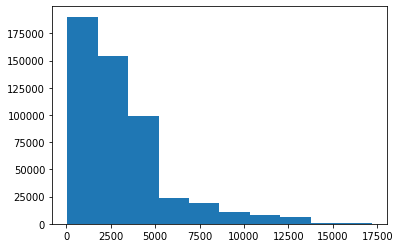

In [38]:
plt.hist(df.Dist_Center)

#### Categorical Variables to Dummy

In [7]:
X_categorical = pd.get_dummies(df[x_categorical], prefix_sep='_', drop_first=True)
X_categorical = X_categorical.fillna('Not Available')

#### Normalization of Numerical Variables

In [8]:
X_numerical = df[x_numerical]
X_numerical.Average_Score = boxcox(df.Average_Score, 3.5)
X_numerical.Total_Number_of_Reviews_Reviewer_Has_Given = boxcox(df.Total_Number_of_Reviews_Reviewer_Has_Given, -0.5)
X_numerical.Dist_Center = boxcox(df.Dist_Center, 0.1)
X_numerical.Dist_Train = boxcox(df.Dist_Train, 0.3)
X_numerical.Dist_Airport = boxcox(df.Dist_Airport, 0.5)
X_numerical.Price = boxcox(df.Price, -0.4)
X_numerical.Reservation_ADR = boxcox(df.Reservation_ADR, -0.3)

C:\Users\Albert\Anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\Albert\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1044: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


#### Response Candidates

In [9]:
y = df[y_col]

#### Merge Information back together

In [10]:
df_model = pd.concat([y, X_numerical, X_categorical], axis=1, sort=False)

In [11]:
df_model.shape

(515738, 73)

In [12]:
df_model.columns

Index(['Diff', 'Diff_Percentage', 'Average_Score',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Close_Landmarks',
       'Dist_Center', 'Dist_Train', 'Dist_Airport', 'food_Neg_Hotel',
       'staff_Neg_Hotel', 'location_Neg_Hotel', 'value_Neg_Hotel',
       'comfort_Neg_Hotel', 'room_Neg_Hotel', 'facilities_Neg_Hotel',
       'cleanliness_Neg_Hotel', 'food_Pos_Hotel', 'staff_Pos_Hotel',
       'location_Pos_Hotel', 'value_Pos_Hotel', 'comfort_Pos_Hotel',
       'room_Pos_Hotel', 'facilities_Pos_Hotel', 'cleanliness_Pos_Hotel',
       'Price', 'Reservation_ADR', 'Review_Month_10', 'Review_Month_11',
       'Review_Month_12', 'Review_Month_2', 'Review_Month_3', 'Review_Month_4',
       'Review_Month_5', 'Review_Month_6', 'Review_Month_7', 'Review_Month_8',
       'Review_Month_9', 'City_Barcelona', 'City_London', 'City_Milan',
       'City_Paris', 'City_Vienna', 'Purpose_Leisure trip',
       'Whom_Family with older children', 'Whom_Family with young children',
       'Whom_Grou

In [127]:
df_model.to_csv('./data/df_model.gz', index_label=False, compression="gzip")